# This notebook does initial exploration of time series models

In [4]:
# Imports

import torch
import torch.nn as nn

import sys
sys.path.append("../")

In [20]:
%cd /pscratch/sd/m/mansisak/PatchTST/PatchTST_supervised

/pscratch/sd/m/mansisak/PatchTST/PatchTST_supervised


In [28]:
# Get model
from models.PatchTST import Model

class model_args:
    enc_in = 7
    seq_len = 96
    pred_len = 96

    e_layers = 2

    n_heads = 8
    d_model = 512
    d_ff = 2048
    dropout = 0.05
    fc_dropout =  0.05
    head_dropout = 0.0

    individual = 0

    patch_len = 16
    stride = 8
    padding_patch = "end"

    revin = 1
    affine = 0
    subtract_last = 0

    decomposition = 0
    kernel_size = 25

model = Model(model_args)    
model

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 8))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=16, out_features=512, bias=True)
      (dropout): Dropout(p=0.05, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0-1): 2 x TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=512, out_features=512, bias=True)
              (W_K): Linear(in_features=512, out_features=512, bias=True)
              (W_V): Linear(in_features=512, out_features=512, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=512, bias=True)
                (1): Dropout(p=0.05, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.05, inplace=F

In [23]:
# Get data
from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Pred
from data_provider.data_factory import data_provider

#https://github.com/msakarvadia/PatchTST/blob/main/PatchTST_supervised/scripts/PatchTST/etth1.sh
class data_args:
    data = 'ETTh1' #TODO was "ETTm1"
    root_path = '/pscratch/sd/m/mansisak/PatchTST/PatchTST_supervised/dataset'
    data_path = 'ETTh1.csv'
    features = 'M'
    target = 'OT'
    freq = "h"
    embed = 'timeF'
    seq_len = 96
    label_len = 48
    pred_len = 48
    num_workers = 1
    batch_size = 128

data_set, data_loader = data_provider(args=data_args, flag="pred") #flag = pred | test | train

pred 1


In [30]:
# inference on single data point
iter_count = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(data_loader):
    iter_count += 1
    #model_optim.zero_grad()
    batch_x = batch_x.float().to(device)

    batch_y = batch_y.float().to(device)
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, data_args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :data_args.label_len, :], dec_inp], dim=1).float().to(device)

    outputs = model(batch_x)
    break

In [31]:
outputs.shape

torch.Size([1, 96, 7])

# Decode intermediate model layers during inference

In [49]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

In [56]:
model

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 8))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=16, out_features=512, bias=True)
      (dropout): Dropout(p=0.05, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0-1): 2 x TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=512, out_features=512, bias=True)
              (W_K): Linear(in_features=512, out_features=512, bias=True)
              (W_V): Linear(in_features=512, out_features=512, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=512, bias=True)
                (1): Dropout(p=0.05, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.05, inplace=F

In [61]:
num_layers = 2
for i in range(num_layers):
    model.model.backbone.encoder.layers[i].register_forward_hook(get_activation(f"layer_{i}_output"))

In [62]:
# inference on single data point
iter_count = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(data_loader):
    iter_count += 1
    #model_optim.zero_grad()
    batch_x = batch_x.float().to(device)

    batch_y = batch_y.float().to(device)
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, data_args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :data_args.label_len, :], dec_inp], dim=1).float().to(device)

    outputs = model(batch_x)
    break

In [63]:
activation.keys()

dict_keys(['output_hook', 'layer_0_output', 'layer_1_output'])

In [102]:
activation[f'layer_{j}_output'][-1].cpu().detach().numpy().shape

(7, 8, 12, 12)

In [98]:
torch.unsqueeze(activation[f'layer_{j}_output'][0][:,1,:], dim=1).shape

torch.Size([7, 1, 512])

In [100]:
model.model.head

Flatten_Head(
  (flatten): Flatten(start_dim=-2, end_dim=-1)
  (linear): Linear(in_features=6144, out_features=96, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [101]:
6144 / 12

512.0

In [103]:
model.model.head(activation[f'layer_{j}_output'][-2]).cpu().detach().numpy().shape

(7, 96)

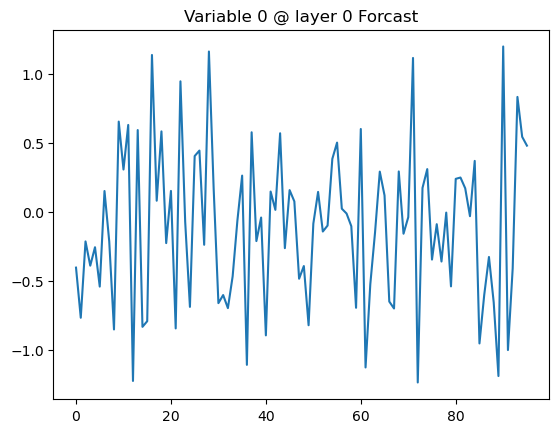

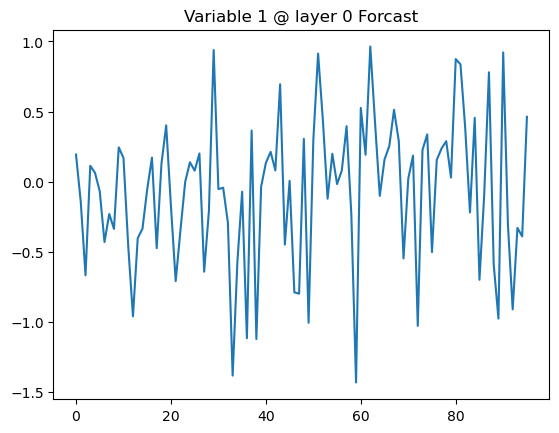

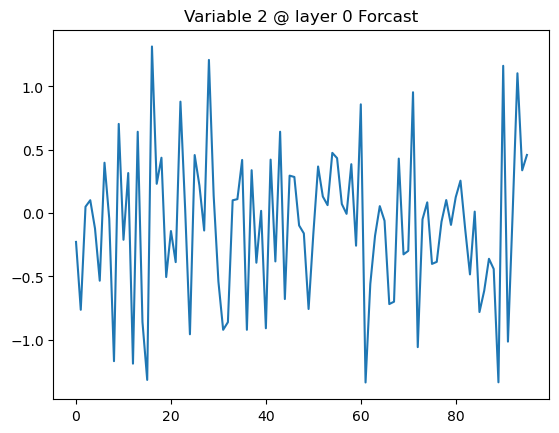

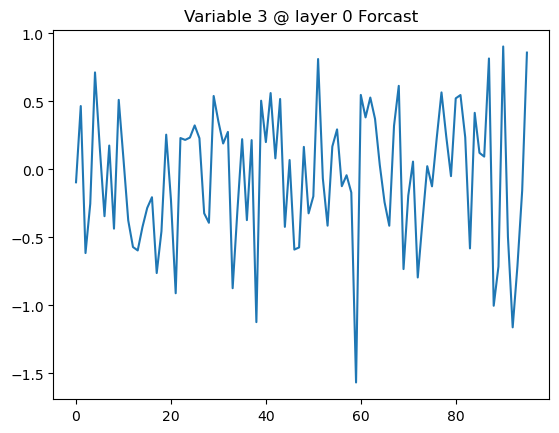

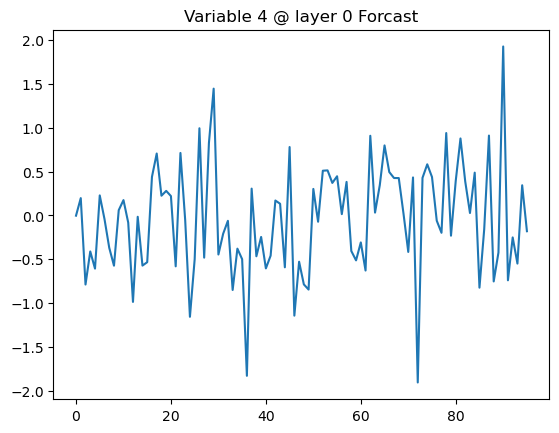

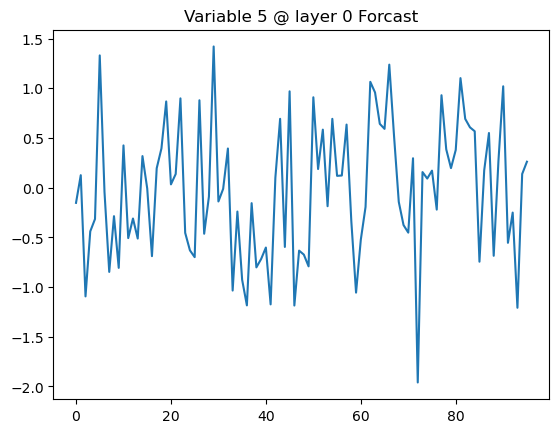

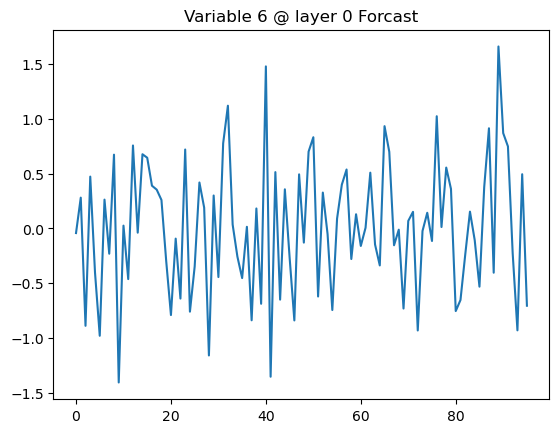

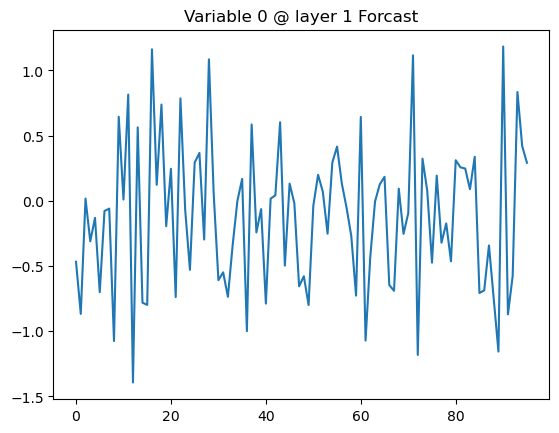

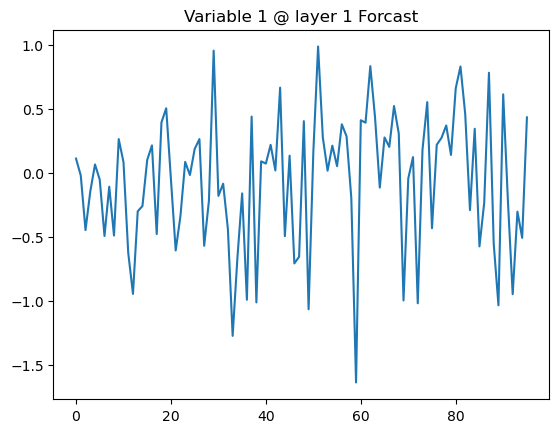

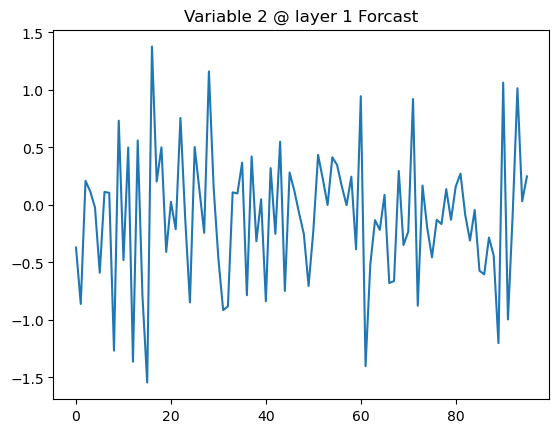

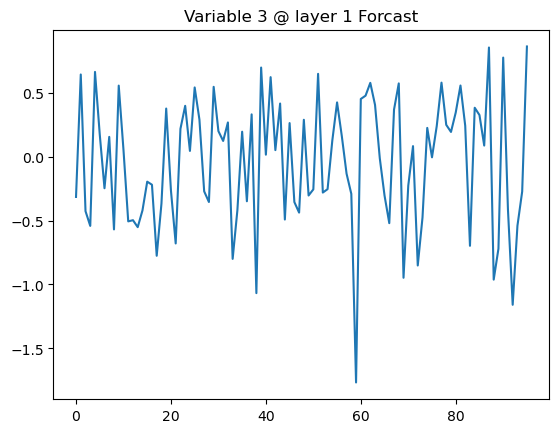

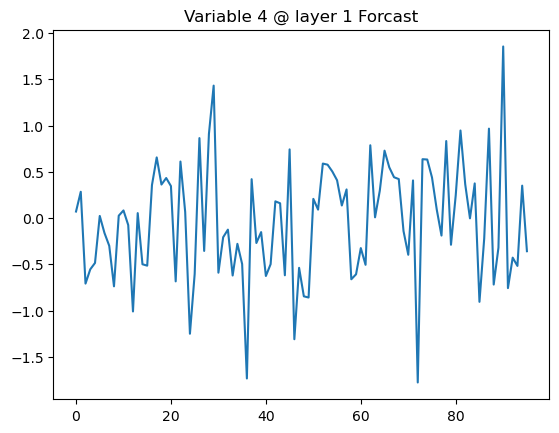

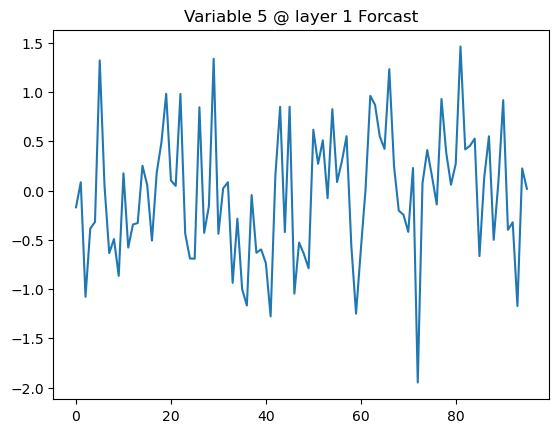

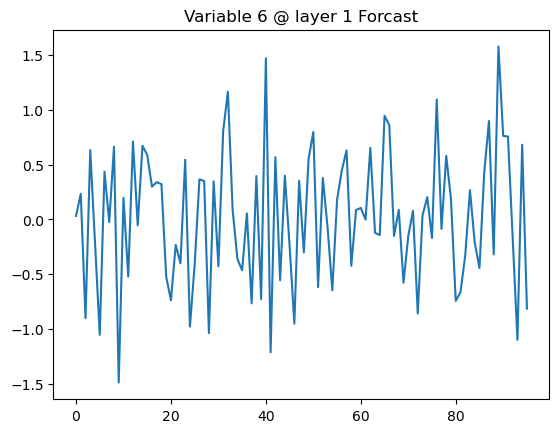

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns


for j in range(num_layers):
    for i in range(7):
        data = model.model.head(activation[f'layer_{j}_output'][-2]).cpu().detach().numpy()[i]
        plt.plot(data)
        plt.title(f"Variable {i} @ layer {j} Forcast")

        plt.show()

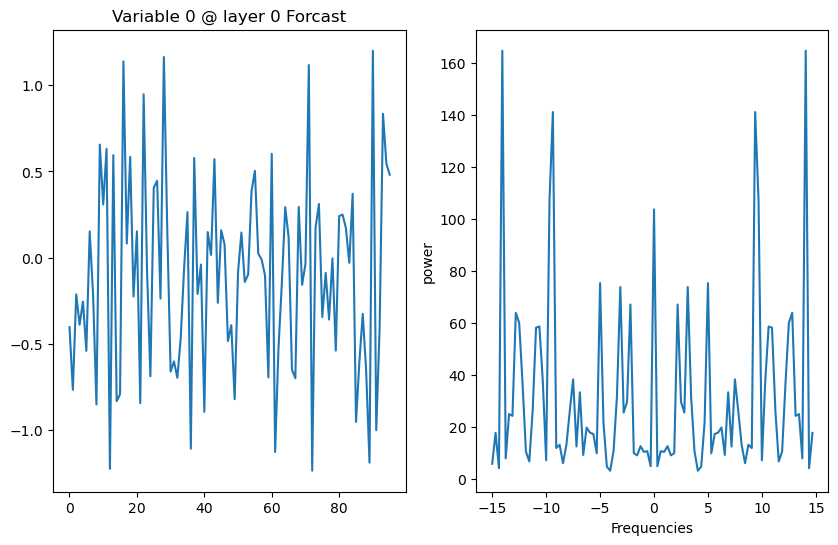

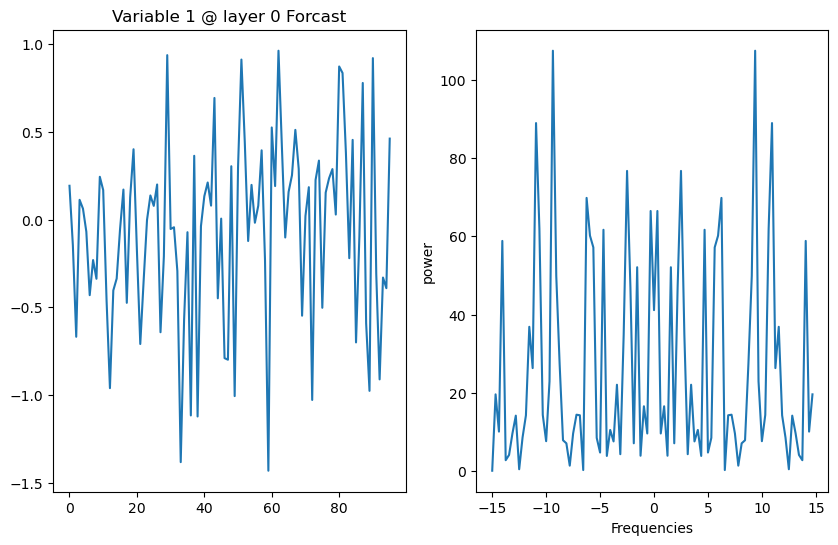

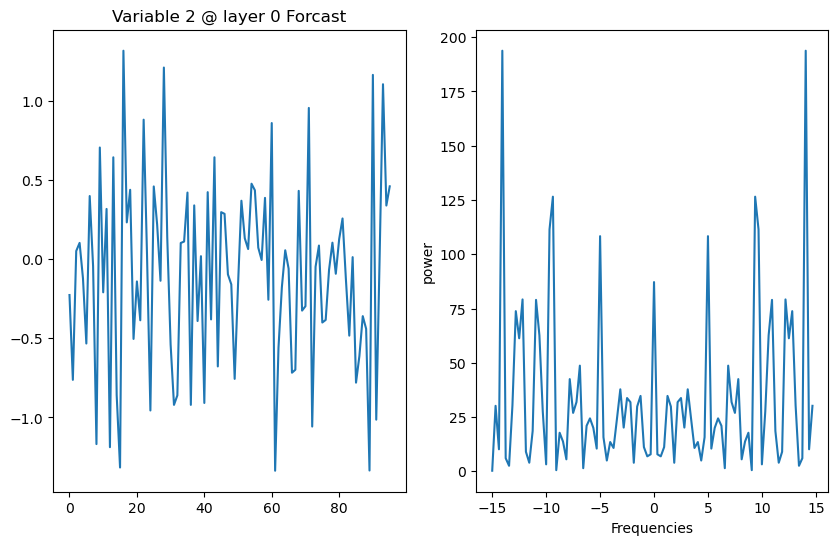

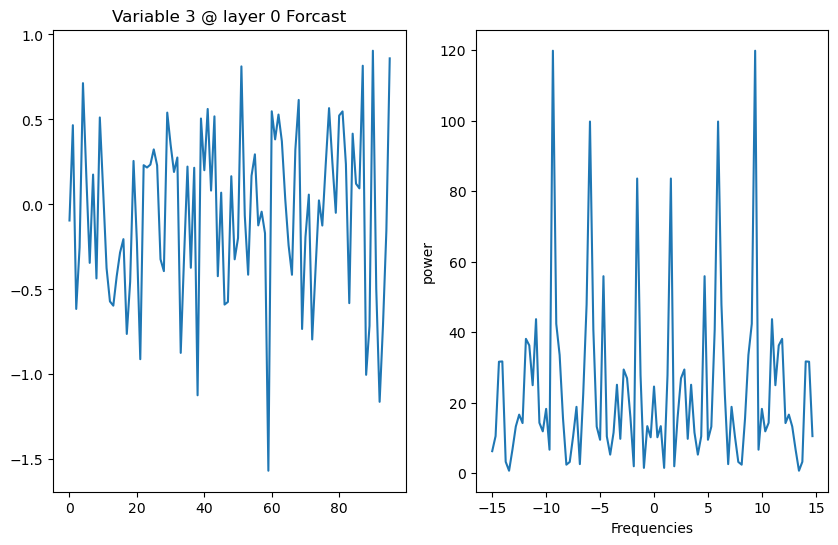

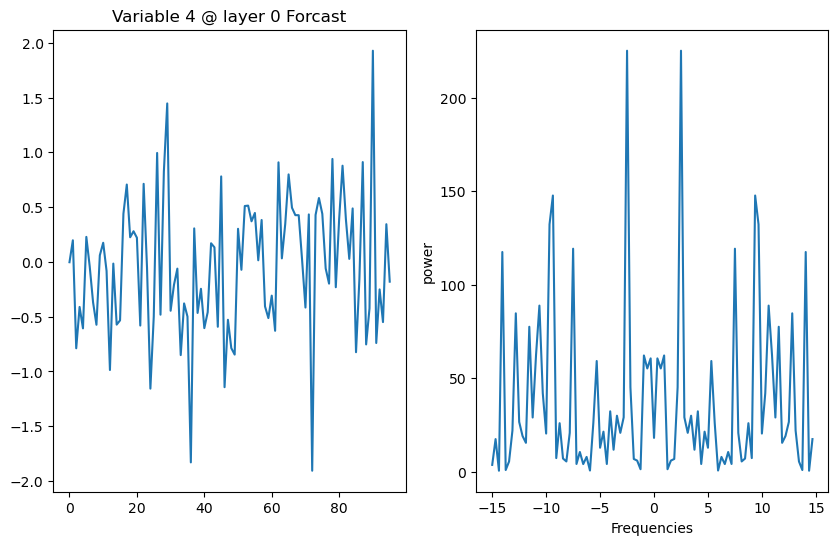

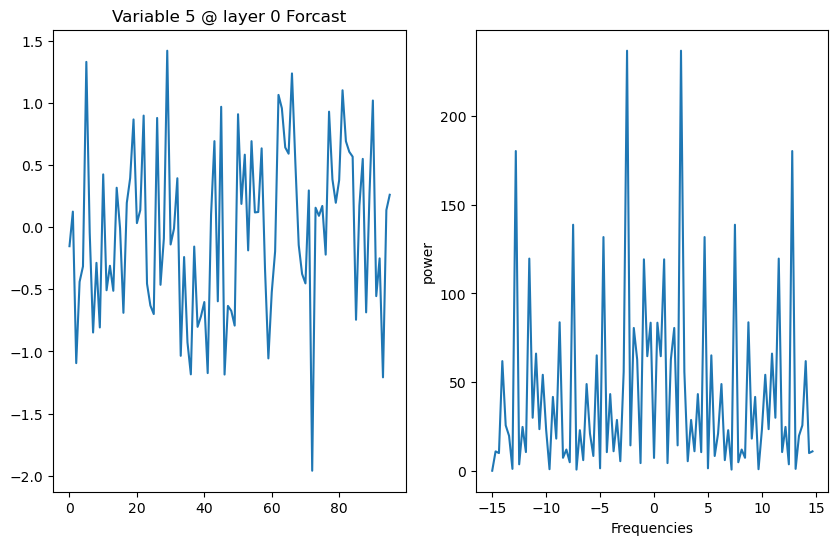

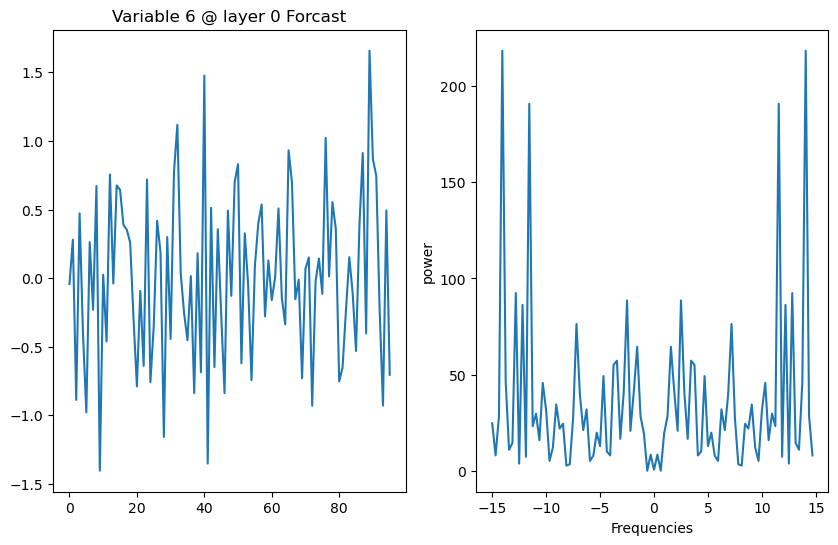

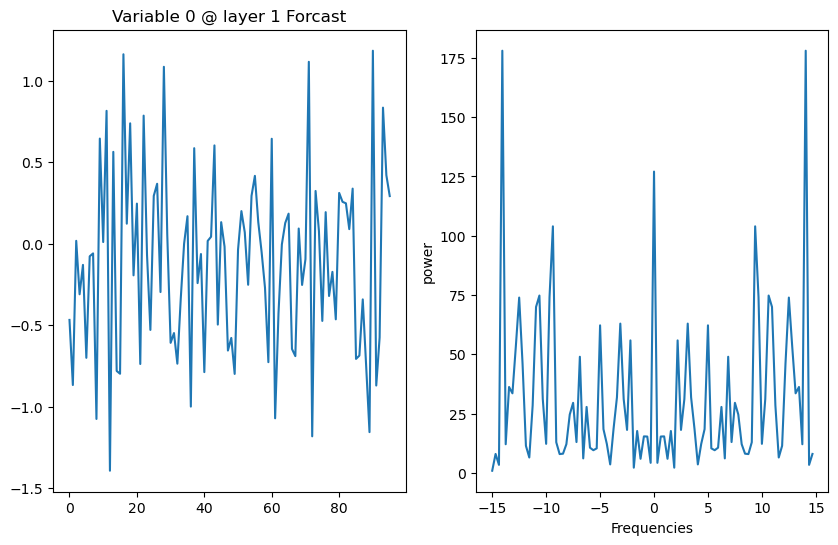

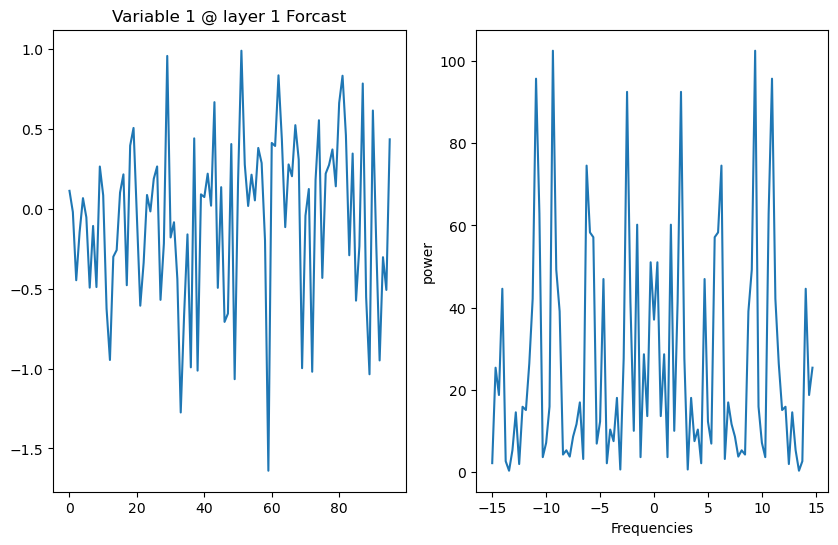

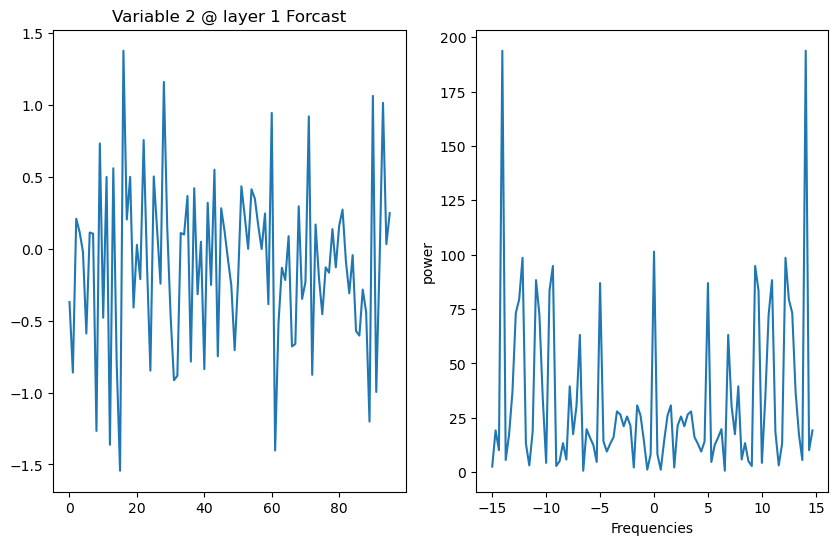

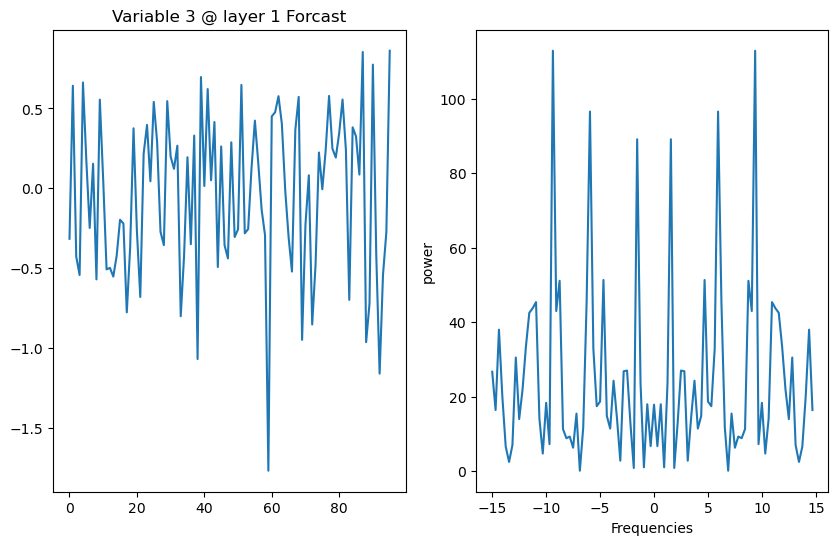

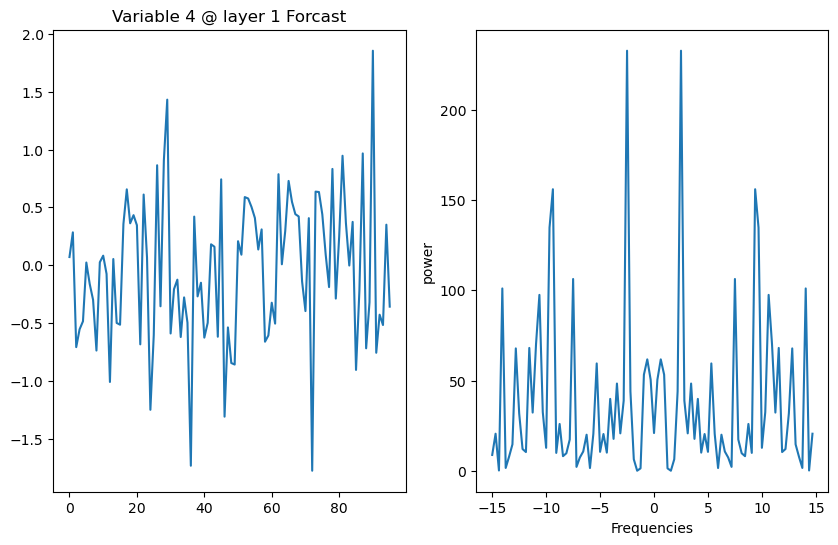

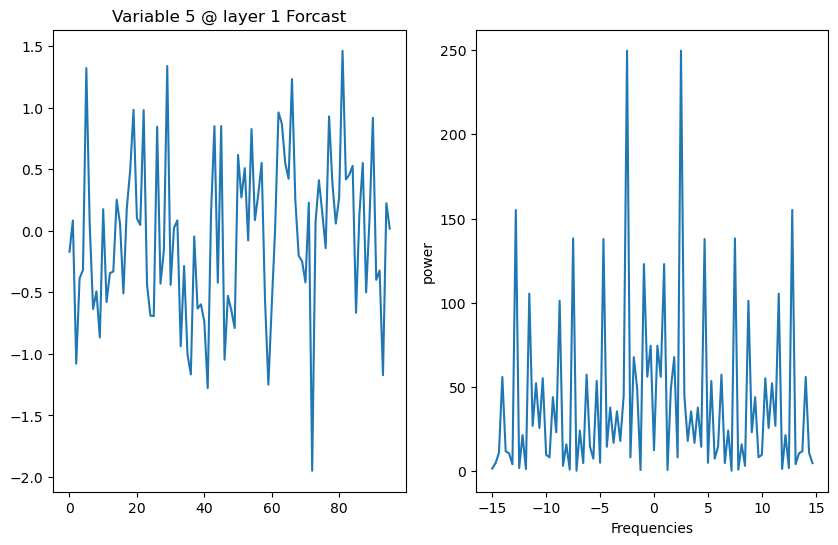

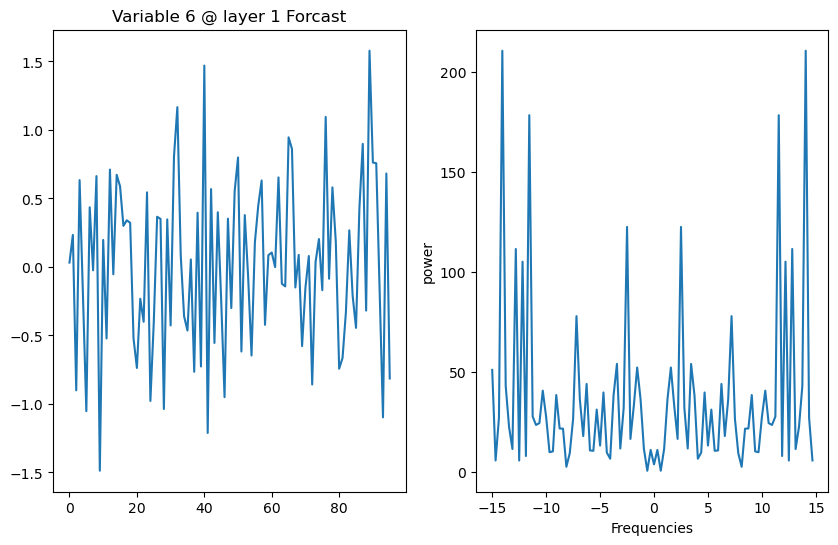

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns


for j in range(num_layers):
    for i in range(7):
        fig, axs = plt.subplots( 1, 2, sharex="col", sharey=False, figsize=(10,6))
        data = model.model.head(activation[f'layer_{j}_output'][-2]).cpu().detach().numpy()[i]
        ax = sns.lineplot(data, ax=axs[0])
        ax.set_title(f"Variable {i} @ layer {j} Forcast")
        
      
        ps = np.abs(np.fft.fft(data))**2 # This is the power spectrum density
        time_step = 1 / 30 # Random time step
        freqs = np.fft.fftfreq(data.size, time_step) #These are the frequences sampled every 1/30 time steps
        idx = np.argsort(freqs)

        axs[1] = plt.plot(freqs[idx], ps[idx])
        plt.xlabel("Frequencies")
        plt.ylabel("power")
        plt.show()

Text(0, 0.5, 'power')

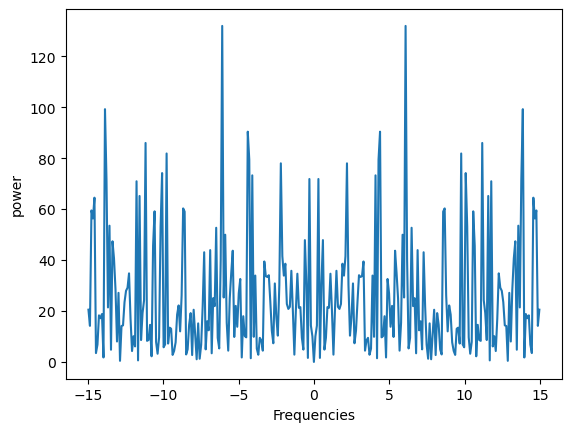

In [77]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

data = np.random.rand(301) - 0.5 #This is the random data
ps = np.abs(np.fft.fft(data))**2 # This is the power spectrum density


time_step = 1 / 30
freqs = np.fft.fftfreq(data.size, time_step) #These are the frequences sampled every 1/30 time steps
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])
plt.xlabel("Frequencies")
plt.ylabel("power")